In [1]:
"""Select best AIS model and save the result automatically."""

import os
import yaml

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Parameters
timestep = 8
rnn_type = 'GRU'

In [3]:
df_hparam_score = []
i = 0

root_dir_name = f'AIS_{rnn_type}_model_asNormThreshold_dt{timestep}h_grid__'

for lr in [1e-5, 3e-5, 0.0001, 0.0003, 0.001, 0.0005]:
    for latent in [8, 16, 32, 64, 128]:
        df = pd.read_csv('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
                        + root_dir_name 
                        + f'/dt{timestep}h_lr{lr}_latent{latent}/metrics.csv')
        hparams_file = ('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
                        + root_dir_name 
                        + f'/dt{timestep}h_lr{lr}_latent{latent}/hparams.yaml')
        
        with open(hparams_file, 'r') as f:
            params_dict = yaml.safe_load(f)

        meta = pd.Series(params_dict, name='value')
        meta.index.name = 'key'
        df_hparam_score.append([i, meta.loc['latent_dim'].item(), meta.loc['lr'].item(), 
                                df['val_loss'].min(), 
                                df[df['val_loss'] == df['val_loss'].min()]['val_mse'].iloc[0]])
        i = i + 1

df_hparam_score = pd.DataFrame(df_hparam_score, columns=['trial', 'latent_dim', 'lr', 'val_loss', 'val_mse'])

In [4]:
df_hparam_score

,trial,latent_dim,lr,val_loss,val_mse
0,0,8.0,0.00001,252.179428,0.640163
1,1,16.0,0.00001,241.338181,0.533623
2,2,32.0,0.00001,234.874634,0.470120
3,3,64.0,0.00001,233.090408,0.452610
4,4,128.0,0.00001,232.657730,0.448358
5,5,8.0,0.00003,250.804230,0.626633
6,6,16.0,0.00003,238.801712,0.508676
7,7,32.0,0.00003,232.629562,0.448064
8,8,64.0,0.00003,232.054276,0.442430
9,9,128.0,0.00003,231.737289,0.439306


In [5]:
os.makedirs('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
            + root_dir_name 
            + f'/results/',
            exist_ok=True)

In [6]:
df_hparam_score.to_csv('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
                        + root_dir_name 
                        + f'/results/AIS_result_asNormThreshold_dt{timestep}h.csv',
                         index=False)

In [7]:
best_trial = df_hparam_score['val_loss'].idxmin()

In [8]:
df_hparam_score.loc[best_trial]

trial          22.000000
latent_dim     32.000000
lr              0.001000
val_loss      231.308853
val_mse         0.435074
Name: 22, dtype: float64

In [9]:
df_hparam_score.loc[best_trial].to_csv(
    '/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
   + root_dir_name 
   + f'/results/best_ckpt_data.csv')

In [10]:
best_lr = float(df_hparam_score.loc[best_trial]['lr'])
best_latent = int(df_hparam_score.loc[best_trial]['latent_dim'])

df = pd.read_csv('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
                + root_dir_name 
                + f'/dt{timestep}h_lr{best_lr}_latent{best_latent}/metrics.csv')
df_1 = df.groupby('epoch').mean().reset_index()

In [11]:
best_epoch = df_1['val_loss'].idxmin()
print(best_epoch)

312


In [12]:
best_step = 1
df_1[df_1['epoch'] == best_epoch]

,epoch,step,train_loss,val_loss,val_mse
312,312,31586.666667,230.463066,231.308853,0.435074


In [13]:
best_step = 7260

best_ckpt_path = ('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/'
                  + root_dir_name
                  + f'/dt{timestep}h_lr{best_lr}_latent{best_latent}'
                  + f'/checkpoints/epoch={best_epoch}-step=*.ckpt')

import glob
matches_ckpt = glob.glob(best_ckpt_path)

best_ckpt_path = matches_ckpt[0]

In [14]:
matches_ckpt

['/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/AIS_GRU_model_asNormThreshold_dt8h_grid__/dt8h_lr0.001_latent32/checkpoints/epoch=312-step=31613.ckpt',
 '/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/AIS_GRU_model_asNormThreshold_dt8h_grid__/dt8h_lr0.001_latent32/checkpoints/epoch=312-step=31613-v1.ckpt']

In [15]:
with open(('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
        + root_dir_name + '/results/best_ckpt_path.txt'),
        "w", encoding="utf-8") as f:
    f.write(best_ckpt_path)

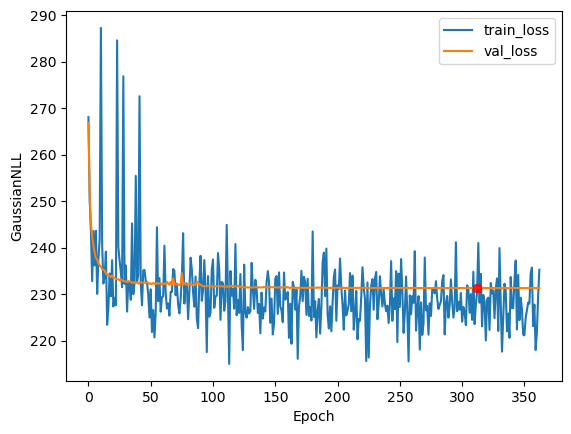

In [16]:
plt.plot(df_1['epoch'], df_1['train_loss'], label='train_loss')
plt.plot(df_1['epoch'], df_1['val_loss'], label='val_loss')
plt.plot(best_epoch, df_1['val_loss'].iloc[best_epoch], 'ro', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('GaussianNLL')
plt.legend()
plt.savefig('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
            + root_dir_name  
            + f'/results/best_trial_GaussianNLL_dt{timestep}h_lr{best_lr}_latent{best_latent}.pdf')

plt.show()

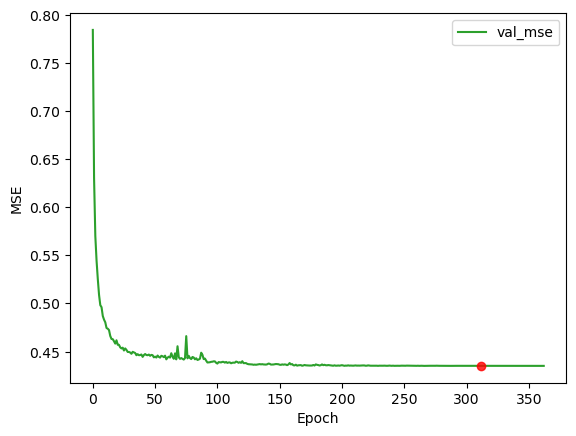

In [17]:

plt.plot(df_1['epoch'], df_1['val_mse'], label='val_mse', color='tab:green')
plt.plot(best_epoch, df_1['val_mse'].iloc[best_epoch], 'ro', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('/local/scratch/ysun564/project/OfflineRL_TimeStep/RL_mimic_sepsis/b_train_encoder/logs/' 
            + root_dir_name  
            + f'/results/best_trial_MSE_dt{timestep}h_lr{best_lr}_latent{best_latent}.pdf')
plt.show()